**Table of contents**<a id='toc0_'></a>    
- [Prediction of energy consumption](#toc1_)    
  - [Importing packages and reading data](#toc1_1_)    
  - [Data preprocessing and analysis](#toc1_2_)    
    - [Information about the dataset](#toc1_2_1_)    
    - [Checking missing values](#toc1_2_2_)    
    - [Identify duplicates](#toc1_2_3_)    
    - [Identify mistyped data](#toc1_2_4_)    
    - [Columns info](#toc1_2_5_)    
    - [Outliers](#toc1_2_6_)    
      - [with Boxplot](#toc1_2_6_1_)    
      - [with IQR](#toc1_2_6_2_)    
    - [Feature Engineering](#toc1_2_7_)    
  - [Model building and Evaluation](#toc1_3_)    
    - [Testing different Regression Models with all features](#toc1_3_1_)    
    - [Different Scalers for Linear Regression](#toc1_3_2_)    
    - [RFE Method for Feature Selection](#toc1_3_3_)    
    - [Grid Search for Hyperparameters](#toc1_3_4_)    
    - [Random Search for Hyperparameters](#toc1_3_5_)    
    - [Linear Regression](#toc1_3_6_)    
    - [Ridge Regression](#toc1_3_7_)    
    - [Lasso Regression](#toc1_3_8_)    
    - [ElasticNet Regression](#toc1_3_9_)    
    - [LinearSVR](#toc1_3_10_)    
      - [with StandardScaler](#toc1_3_10_1_)    
      - [with MinMaxScaler](#toc1_3_10_2_)    
      - [with RobustScaler](#toc1_3_10_3_)    
    - [Ensemble method](#toc1_3_11_)    
      - [Averaging](#toc1_3_11_1_)    
      - [Stacking](#toc1_3_11_2_)    
    - [Discussion](#toc1_3_12_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Prediction of energy consumption](#toc0_)

## <a id='toc1_1_'></a>[Importing packages and reading data](#toc0_)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
from numpy import mean
from numpy import std
from sklearn.preprocessing import LabelBinarizer,RobustScaler, StandardScaler, MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, RepeatedKFold
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, ElasticNet, Ridge
from sklearn.svm import LinearSVR
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import StackingRegressor

import warnings
warnings.filterwarnings('ignore')

data = pd.read_csv("data\Steel_industry_data.csv")

## <a id='toc1_2_'></a>[Data preprocessing and analysis](#toc0_)

Data preview

In [3]:
data.head()

,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type
0,01/01/2018 00:15,3.17,2.95,0.0,0.0,73.21,100.0,900,Weekday,Monday,Light_Load
1,01/01/2018 00:30,4.00,4.46,0.0,0.0,66.77,100.0,1800,Weekday,Monday,Light_Load
2,01/01/2018 00:45,3.24,3.28,0.0,0.0,70.28,100.0,2700,Weekday,Monday,Light_Load
3,01/01/2018 01:00,3.31,3.56,0.0,0.0,68.09,100.0,3600,Weekday,Monday,Light_Load
4,01/01/2018 01:15,3.82,4.50,0.0,0.0,64.72,100.0,4500,Weekday,Monday,Light_Load


Shape of data

In [4]:
data.shape

(35040, 11)

### <a id='toc1_2_1_'></a>[Information about the dataset](#toc0_)

Description of variables:
| **Variable**                    | **Type**    | **Measurement**                       |
|---------------------------------|-------------|---------------------------------------|
| Industry Energy Consumption     | Continuous  | kWh                                   |
| Lagging Current reactive power  | Continuous  | kVarh                                 |
| Leading Current reactive power  | Continuous  | kVarh                                 |
| tCO2(CO2)                       | Continuous  |  ppm                                  |
| Lagging Current power factor    | Continuous  | %                                     |
| Leading Current Power factor    | Continuous  | %                                     |
| Number of Seconds from midnight | Continuous  | s                                     |
| Week status                     | Categorical | Weekend (0) or a Weekday(1)           |
| Day of week                     | Categorical | Sunday, Monday...Saturday             |
| Load Type                       | Categorical | Light Load, Medium Load, Maximum Load |
|                                 |             |                                       |

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35040 entries, 0 to 35039
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   date                                  35040 non-null  object 
 1   Usage_kWh                             35040 non-null  float64
 2   Lagging_Current_Reactive.Power_kVarh  35040 non-null  float64
 3   Leading_Current_Reactive_Power_kVarh  35040 non-null  float64
 4   CO2(tCO2)                             35040 non-null  float64
 5   Lagging_Current_Power_Factor          35040 non-null  float64
 6   Leading_Current_Power_Factor          35040 non-null  float64
 7   NSM                                   35040 non-null  int64  
 8   WeekStatus                            35040 non-null  object 
 9   Day_of_week                           35040 non-null  object 
 10  Load_Type                             35040 non-null  object 
dtypes: float64(6), 

### <a id='toc1_2_2_'></a>[Checking missing values](#toc0_)

In [6]:
data.isnull().sum()

date                                    0
Usage_kWh                               0
Lagging_Current_Reactive.Power_kVarh    0
Leading_Current_Reactive_Power_kVarh    0
CO2(tCO2)                               0
Lagging_Current_Power_Factor            0
Leading_Current_Power_Factor            0
NSM                                     0
WeekStatus                              0
Day_of_week                             0
Load_Type                               0
dtype: int64

### <a id='toc1_2_3_'></a>[Identify duplicates](#toc0_)

In [7]:
dups = data.duplicated()
data[dups]

,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type


### <a id='toc1_2_4_'></a>[Identify mistyped data](#toc0_)

Check numeric

In [8]:
numeric = data.applymap(lambda x: isinstance(x, (int, float)))['Usage_kWh']
data[~numeric]

,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type


Check string

In [9]:
strings = data.applymap(lambda x: isinstance(x, (str)))['Day_of_week']
data[~strings]

,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type


### <a id='toc1_2_5_'></a>[Columns info](#toc0_)

Column 'WeekStatus' values:

In [10]:
data['WeekStatus'].value_counts()

Weekday    25056
Weekend     9984
Name: WeekStatus, dtype: int64

Column 'Load_Type' values:

In [11]:
data['Load_Type'].value_counts()

Light_Load      18072
Medium_Load      9696
Maximum_Load     7272
Name: Load_Type, dtype: int64

Mean value

In [12]:
data.mean(numeric_only=True)

Usage_kWh                                  27.386892
Lagging_Current_Reactive.Power_kVarh       13.035384
Leading_Current_Reactive_Power_kVarh        3.870949
CO2(tCO2)                                   0.011524
Lagging_Current_Power_Factor               80.578056
Leading_Current_Power_Factor               84.367870
NSM                                     42750.000000
dtype: float64

Median value

In [13]:
data.median(numeric_only=True)

Usage_kWh                                   4.57
Lagging_Current_Reactive.Power_kVarh        5.00
Leading_Current_Reactive_Power_kVarh        0.00
CO2(tCO2)                                   0.00
Lagging_Current_Power_Factor               87.96
Leading_Current_Power_Factor              100.00
NSM                                     42750.00
dtype: float64

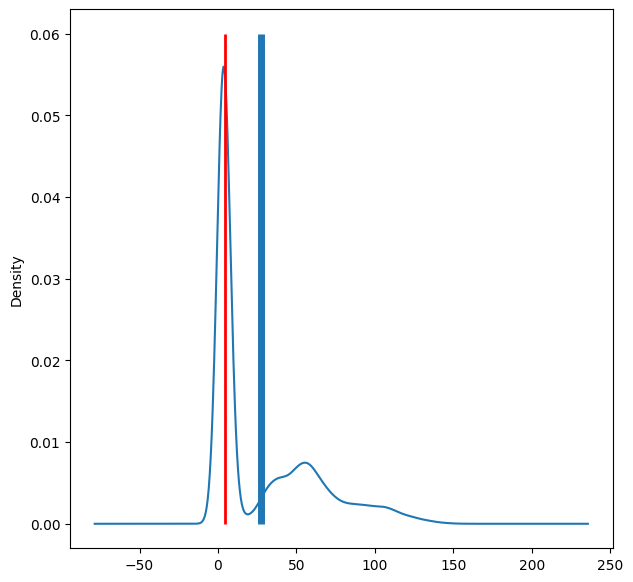

In [14]:
data['Usage_kWh'].plot(kind="density", figsize=(7,7))
plt.vlines(data['Usage_kWh'].mean(), ymin = 0, ymax = 0.06, linewidth = 5.0)
plt.vlines(data['Usage_kWh'].median(), ymin=0, ymax=0.06, linewidth=2.0, color="red")

Mode value

In [15]:
data.mode()

,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type
0,01/01/2018 00:00,3.06,0.0,0.0,0.0,100.0,100.0,0.0,Weekday,Monday,Light_Load
1,01/01/2018 00:15,NaN,NaN,NaN,NaN,NaN,NaN,900.0,NaN,NaN,NaN
2,01/01/2018 00:30,NaN,NaN,NaN,NaN,NaN,NaN,1800.0,NaN,NaN,NaN
3,01/01/2018 00:45,NaN,NaN,NaN,NaN,NaN,NaN,2700.0,NaN,NaN,NaN
4,01/01/2018 01:00,NaN,NaN,NaN,NaN,NaN,NaN,3600.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
35035,31/12/2018 22:45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35036,31/12/2018 23:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35037,31/12/2018 23:15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35038,31/12/2018 23:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Variance

In [16]:
data['Usage_kWh'].var()

1118.5265340538938

Standard deviation

In [17]:
data['Usage_kWh'].std()

33.44437970801513

Percentiles

In [18]:
percentiles = np.percentile(data['Usage_kWh'], [0, 25, 50, 75, 100])
percentiles

array([  0.    ,   3.2   ,   4.57  ,  51.2375, 157.18  ])

'Usage_kWh' column description:

In [19]:
desc_stat = stats.describe(data['Usage_kWh'], ddof = 1, bias = False)
desc_stat

DescribeResult(nobs=35040, minmax=(0.0, 157.18), mean=27.386892408675795, variance=1118.526534053894, skewness=1.1973938227692211, kurtosis=0.3913856014239281)

Data description

In [20]:
data.describe()

,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM
count,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000
mean,27.386892,13.035384,3.870949,0.011524,80.578056,84.367870,42750.000000
std,33.444380,16.306000,7.424463,0.016151,18.921322,30.456535,24940.534317
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.200000,2.300000,0.000000,0.000000,63.320000,99.700000,21375.000000
50%,4.570000,5.000000,0.000000,0.000000,87.960000,100.000000,42750.000000
75%,51.237500,22.640000,2.090000,0.020000,99.022500,100.000000,64125.000000
max,157.180000,96.910000,27.760000,0.070000,100.000000,100.000000,85500.000000


Usage_kWh vs Day of Week

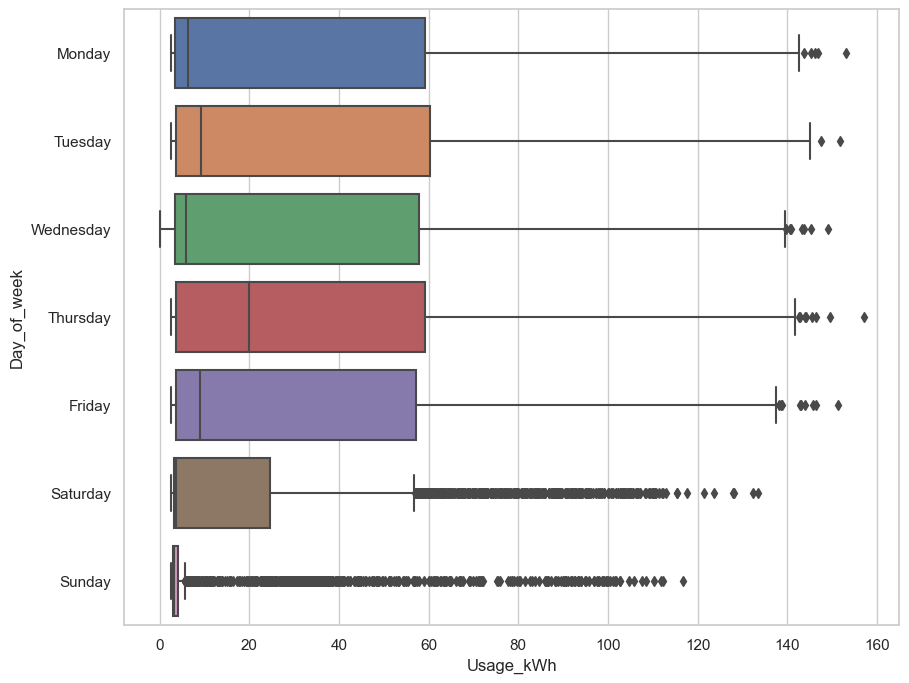

In [21]:
sns.set(style="whitegrid")
plt.figure(figsize=(10,8))
ax = sns.boxplot(x='Usage_kWh', data=data, y='Day_of_week', orient="h")

Correlation map

<AxesSubplot: >

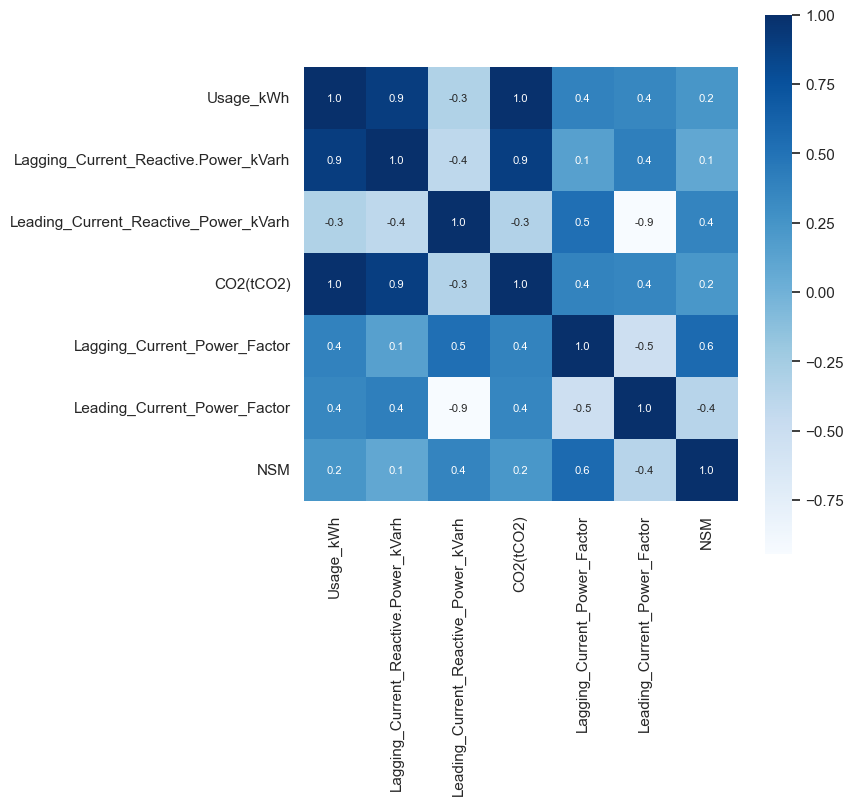

In [22]:
correlation = data.corr()
plt.figure(figsize=(7,7))
sns.heatmap(correlation, cbar=True, square=True, fmt='.1f', annot=True, annot_kws={'size':8}, cmap='Blues')


Day of Week

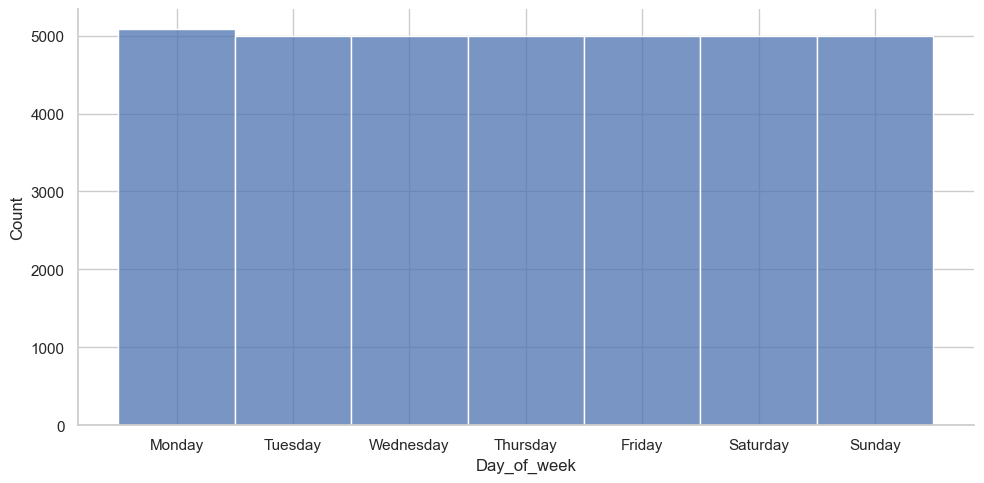

In [23]:
sns.displot(data['Day_of_week'], height=5, aspect=2)

### <a id='toc1_2_6_'></a>[Outliers](#toc0_)

#### <a id='toc1_2_6_1_'></a>[with Boxplot](#toc0_)

{'whiskers': [<matplotlib.lines.Line2D at 0x123fcc01750>,
 'caps': [<matplotlib.lines.Line2D at 0x123fcc01b70>,
 'boxes': [<matplotlib.lines.Line2D at 0x123fcc014b0>,
 'medians': [<matplotlib.lines.Line2D at 0x123fcc020b0>,
 'fliers': [<matplotlib.lines.Line2D at 0x123fcc02350>,
 'means': []}

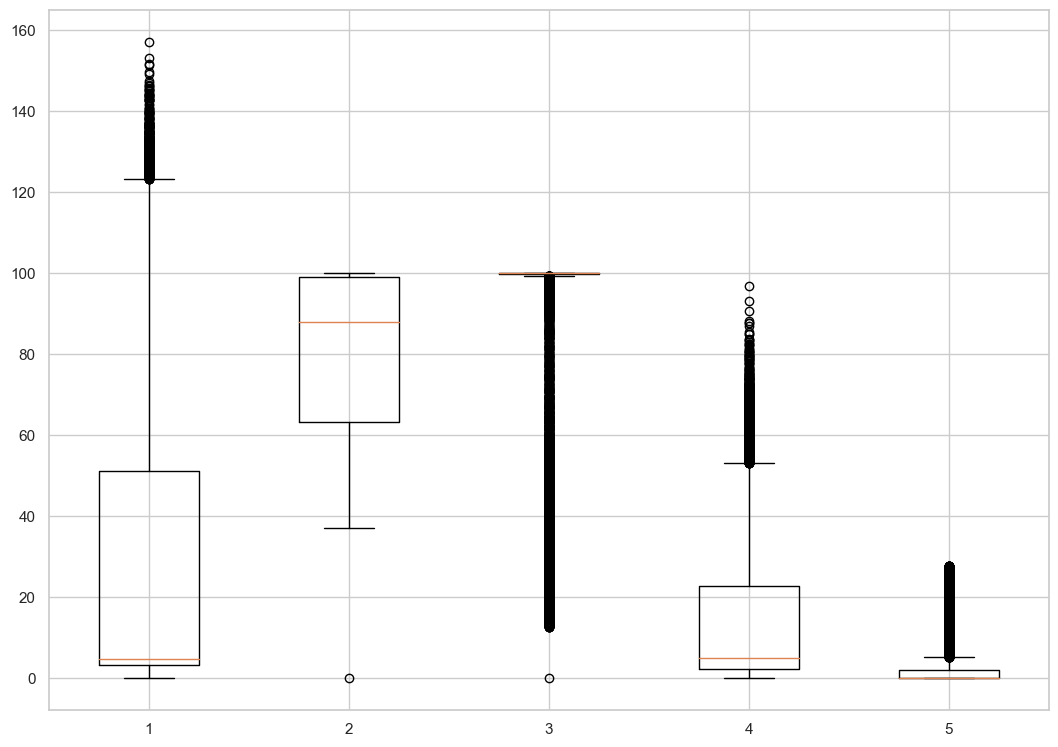

In [24]:
fig = plt.figure(figsize =(10, 7))
ax = fig.add_axes([0, 0, 1, 1])
ax.boxplot([data['Usage_kWh'], data['Lagging_Current_Power_Factor'], data['Leading_Current_Power_Factor'], data['Lagging_Current_Reactive.Power_kVarh'], data['Leading_Current_Reactive_Power_kVarh']])

In [25]:
data.skew(numeric_only=True)

Usage_kWh                               1.197394
Lagging_Current_Reactive.Power_kVarh    1.437899
Leading_Current_Reactive_Power_kVarh    1.734314
CO2(tCO2)                               1.149355
Lagging_Current_Power_Factor           -0.606126
Leading_Current_Power_Factor           -1.511984
NSM                                     0.000000
dtype: float64

#### <a id='toc1_2_6_2_'></a>[with IQR](#toc0_)

In [26]:
def outliers_detection(feature):
    percentiles = np.percentile(feature, [25,75])

    iqr = stats.iqr(feature)
    lower_limit = percentiles[0] - 1.5 * iqr
    upper_limit = percentiles[1] + 1.5 * iqr
    filtered = data[(feature <= lower_limit) & (feature >= upper_limit)] 
    return filtered.size

In [27]:
outliers_detection(data['Usage_kWh'])

0

In [28]:
outliers_detection(data['Leading_Current_Reactive_Power_kVarh'])

0

In [29]:
outliers_detection(data['Lagging_Current_Reactive.Power_kVarh'])

0

In [30]:
outliers_detection(data['Lagging_Current_Power_Factor'])

0

In [31]:
outliers_detection(data['Leading_Current_Power_Factor'])

0

In [32]:
outliers_detection(data['CO2(tCO2)'])

0

### <a id='toc1_2_7_'></a>[Feature Engineering](#toc0_)

Encoding Nominal Categorial Data

In [33]:
one_hot = LabelBinarizer()

encoded_weekstatus = one_hot.fit_transform(data['WeekStatus'])
data['WeekStatus'] = one_hot.fit_transform(data['WeekStatus'])
print(one_hot.classes_)
print(encoded_weekstatus)

encoded_load_type = one_hot.fit_transform(data['Load_Type'])
data['Load_Type'] = one_hot.fit_transform(data['Load_Type'])

print(one_hot.classes_)
encoded_load_type

['Weekday' 'Weekend']
[[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]
['Light_Load' 'Maximum_Load' 'Medium_Load']


array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       ...,
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0]])

Encoding Ordinal Categorial Data

In [34]:
scale_mapper = {"Monday": 1,
                "Tuesday": 2,
                "Wednesday": 3,
                "Thursday": 4,
                "Friday": 5,
                "Saturday": 6,
                "Sunday": 7}

encoded_day_of_week = data['Day_of_week'].replace(scale_mapper)
data['Day_of_week'] = data['Day_of_week'].replace(scale_mapper)

print(data['Day_of_week'].value_counts())
#encoded_day_of_week.value_counts()

1    5088
2    4992
3    4992
4    4992
5    4992
6    4992
7    4992
Name: Day_of_week, dtype: int64


Correlation map after encoding categorical data

<AxesSubplot: >

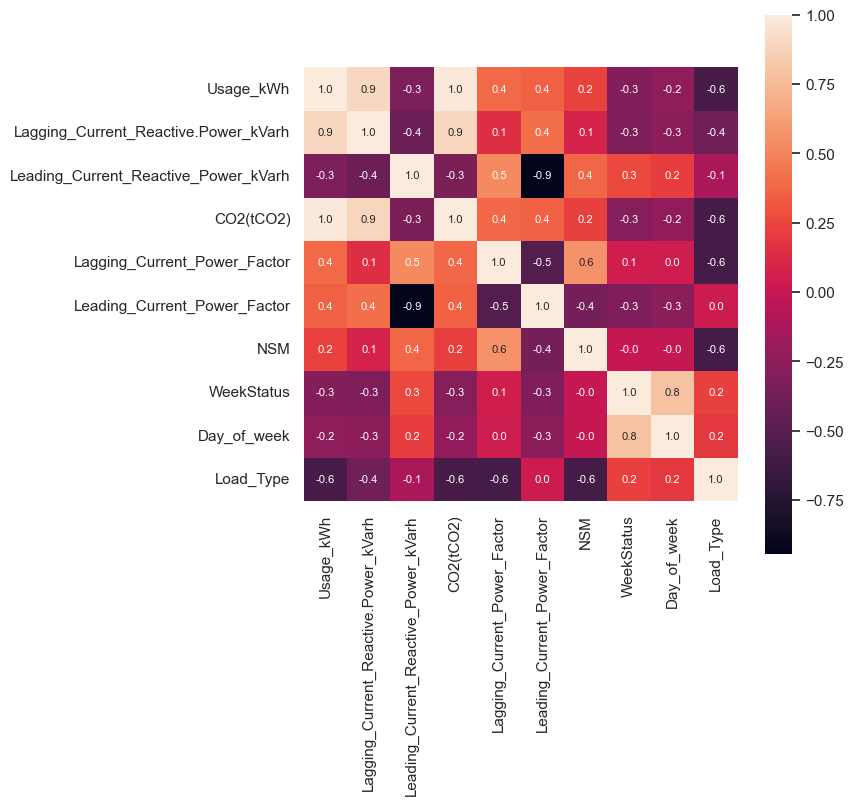

In [35]:
correlation = data.corr()
plt.figure(figsize=(7,7))
sns.heatmap(correlation, cbar=True, square=True, fmt='.1f', annot=True, annot_kws={'size':8})

In [36]:
data = data.loc[:, data.columns != 'date']

## <a id='toc1_3_'></a>[Model building and Evaluation](#toc0_)

### <a id='toc1_3_1_'></a>[Testing different Regression Models with all features](#toc0_)

In [65]:
features, target = data.loc[:, data.columns != 'Usage_kWh'], data['Usage_kWh']
features_train, features_test, target_train, target_test = train_test_split(features, target, random_state=0)

training_score = []
test_score = []

dummy = DummyRegressor(strategy="mean")
dummy.fit(features_train, target_train)
d_score = dummy.score(features_test, target_test)


clf = DummyRegressor(strategy='constant', constant=20)
clf.fit(features_train, target_train)
clf_score = clf.score(features_train, target_train)

lr = LinearRegression()
lr.fit(features_train, target_train)

training_score.append(lr.score(features_train, target_train))
test_score.append(lr.score(features_test, target_test))

lasso = Lasso(alpha=0.1)
lasso.fit(features_train, target_train)

training_score.append(lasso.score(features_train, target_train))
test_score.append(lasso.score(features_test, target_test))

en = ElasticNet(alpha=0.1)
en.fit(features_train, target_train)

training_score.append(en.score(features_train, target_train))
test_score.append(en.score(features_test, target_test))

rlr = Ridge(alpha=0.1)
rlr.fit(features_train, target_train)

training_score.append(rlr.score(features_train, target_train))
test_score.append(rlr.score(features_test, target_test))

scaler = MinMaxScaler()
features_train = scaler.fit_transform(features_train)
features_test = scaler.transform(features_test)
svr_max_scaler = LinearSVR()
svr_max_scaler.fit(features_train, target_train)

training_score.append(svr_max_scaler.score(features_train, target_train))
test_score.append(svr_max_scaler.score(features_test, target_test))

scaler = StandardScaler()
features_train = scaler.fit_transform(features_train)
features_test = scaler.transform(features_test)
svr_standard_scaler = LinearSVR()
svr_standard_scaler.fit(features_train, target_train)

training_score.append(svr_standard_scaler.score(features_train, target_train))
test_score.append(svr_standard_scaler.score(features_test, target_test))


In [38]:
def show_results(score_list: list, labels: list):
    train_score = pd.DataFrame(data = score_list, columns = ['Training_R2'])
    train_score.index = labels
    train_score = (train_score * 100).round(4)
    plt.xticks(rotation=90)
    plt.grid(visible=None)
    plt.scatter(x=train_score.index, y=train_score['Training_R2'], c=train_score['Training_R2'], cmap='Dark2_r')
    for i in range(len(train_score['Training_R2'])):
        plt.annotate(str(train_score['Training_R2'][i]), (i, train_score['Training_R2'][i]), textcoords="offset points", xytext=(0,10))

Training Score

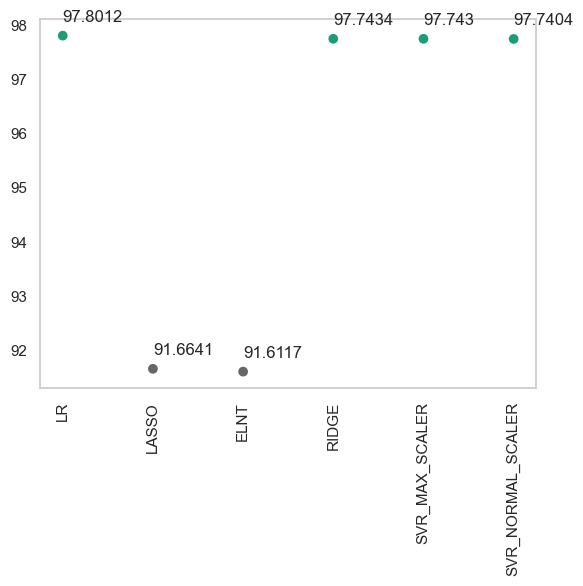

In [66]:
models = ['LR', 'LASSO', 'ELNT', 'RIDGE', 'SVR_MAX_SCALER', 'SVR_NORMAL_SCALER']
show_results(score_list=test_score, labels=models)

Describing data after removing row with all zeroes

In [40]:
data = data[data['Usage_kWh'] != 0]

data.describe()

,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type
count,35039.000000,35039.000000,35039.000000,35039.000000,35039.000000,35039.000000,35039.000000,35039.000000,35039.000000,35039.000000
mean,27.387674,13.035756,3.871059,0.011525,80.580356,84.370278,42751.220069,0.284940,3.991809,0.515740
std,33.444537,16.306084,7.424540,0.016151,18.916695,30.453634,24939.844508,0.451392,2.003455,0.499759
min,2.450000,0.000000,0.000000,0.000000,36.940000,12.500000,0.000000,0.000000,1.000000,0.000000
25%,3.200000,2.300000,0.000000,0.000000,63.320000,99.700000,21600.000000,0.000000,2.000000,0.000000
50%,4.570000,5.000000,0.000000,0.000000,87.960000,100.000000,43200.000000,0.000000,4.000000,1.000000
75%,51.245000,22.640000,2.090000,0.020000,99.025000,100.000000,64350.000000,1.000000,6.000000,1.000000
max,157.180000,96.910000,27.760000,0.070000,100.000000,100.000000,85500.000000,1.000000,7.000000,1.000000


### <a id='toc1_3_2_'></a>[Different Scalers for Linear Regression](#toc0_)

In [41]:
features, target = data.loc[:, data.columns != 'Usage_kWh'], data['Usage_kWh']
features_train, features_test, target_train, target_test = train_test_split(features, target, random_state=0)

testing_score = []
scaler = RobustScaler()
features_train = scaler.fit_transform(features_train)
features_test = scaler.transform(features_test)
model = LinearRegression()
model.fit(features_train, target_train)
testing_score.append(model.score(features_test, target_test))

scaler = MinMaxScaler()
X_train = scaler.fit_transform(features_train)
X_test = scaler.transform(features_test)
model = LinearRegression()
model.fit(features_train, target_train)
testing_score.append(model.score(features_test, target_test))

scaler = StandardScaler()
features_train = scaler.fit_transform(features_train)
features_test = scaler.transform(features_test)
model = LinearRegression()
model.fit(features_train, target_train)
testing_score.append(model.score(features_test, target_test))

nof_list=np.arange(1,9)
high_score=0

Score of LR Models with different scalers

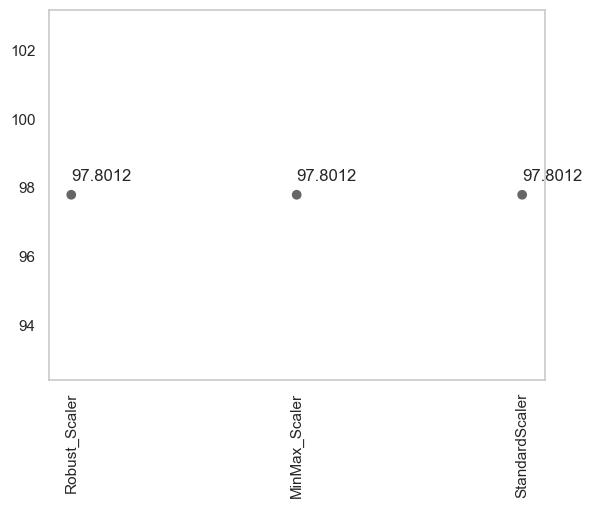

In [42]:
labels = ['Robust_Scaler', 'MinMax_Scaler', 'StandardScaler']
show_results(score_list=testing_score, labels=labels)

### <a id='toc1_3_3_'></a>[RFE Method for Feature Selection](#toc0_)

In [43]:
def rfe_method(model):
    nof_list=np.arange(1,9)            
    high_score=0

    nof=0           
    score_list =[]
    for n in range(len(nof_list)):
        features, target = data.loc[:, data.columns != 'Usage_kWh'], data['Usage_kWh']
        features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.3, random_state=0)

        rfe = RFE(estimator=model, n_features_to_select=nof_list[n])
        features_train_rfe = rfe.fit_transform(features_train,target_train)
        features_test_rfe = rfe.transform(features_test)
        model.fit(features_train_rfe, target_train)
        score = model.score(features_test_rfe, target_test)
        score_list.append(score)
        if(score>high_score):
            high_score = score
            nof = nof_list[n]
    print("Optimum number of features: %d" %nof)
    print("Score with %d features: %f" % (nof, high_score))

    features, target = data.loc[:, data.columns != 'Usage_kWh'], data['Usage_kWh']
    cols = list(features.columns)
    rfe = RFE(estimator=model, n_features_to_select=nof)             
    rfe = rfe.fit(features, target)  
    print(rfe.get_feature_names_out())
    return features[features.columns[rfe.support_]]

### <a id='toc1_3_4_'></a>[Grid Search for Hyperparameters](#toc0_)

In [44]:
def gridsearch(model, space, scoring='neg_mean_absolute_error', cv=10, scaler=None):
    features, target = data.loc[:, data.columns != 'Usage_kWh'], data['Usage_kWh']
    features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.3, random_state=0)

    if scaler is not None:
        features_train = scaler.fit_transform(features_train)

    grid_search = GridSearchCV(model, space, scoring=scoring, n_jobs=-1, cv=cv)
    grid_result = grid_search.fit(features_train, target_train)
    
    print('Grid Search - Best Score: %s' % grid_result.best_score_)
    print('Grid Search - Best Hyperparameters: %s' % grid_result.best_params_)
    return grid_result.best_params_

### <a id='toc1_3_5_'></a>[Random Search for Hyperparameters](#toc0_)

In [45]:
def randomsearch(model, space, scoring='neg_mean_absolute_error', scaler=None):
    features, target = data.loc[:, data.columns != 'Usage_kWh'], data['Usage_kWh']
    features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.3, random_state=0)

    if scaler is not None:
        features_train = scaler.fit_transform(features_train)
        
    randomized_search = RandomizedSearchCV(model, space, scoring=scoring)
    randomized_result = randomized_search.fit(features_train, target_train)
    print('Randomized Search - Best Score: %s' % randomized_result.best_score_)
    print('Randomized Search - Best Hyperparameters: %s' % randomized_result.best_params_)
    return randomized_result.best_params_

In [46]:
def visualize_model(x, y, title):
    plt.title(title)
    plt.plot(x, y, 'o', color='r')

    m, b = np.polyfit(x, y, 1)
    plt.plot(x, m * x + b, color = 'darkblue')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.show()

In [47]:
training_score = []
testing_score = []

### <a id='toc1_3_6_'></a>[Linear Regression](#toc0_)

Grid Search - Best Score: -2.530877780961265
Grid Search - Best Hyperparameters: {'fit_intercept': True}
Randomized Search - Best Score: -2.530236992663218
Randomized Search - Best Hyperparameters: {'fit_intercept': True}
Optimum number of features: 8
Score with 8 features: 0.978820
['Lagging_Current_Reactive.Power_kVarh'
 'Leading_Current_Reactive_Power_kVarh' 'CO2(tCO2)'
 'Lagging_Current_Power_Factor' 'Leading_Current_Power_Factor'
 'WeekStatus' 'Day_of_week' 'Load_Type']
The train score for LR model is 0.9810272405473877
The test score for LR model is 0.9788200200133501


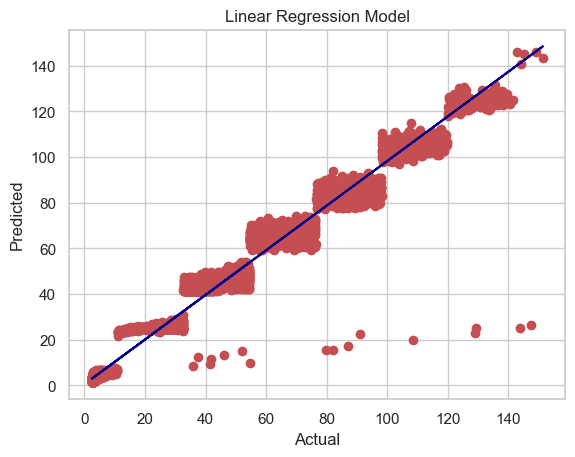

In [48]:
model_lr = LinearRegression()

space = dict()
space['fit_intercept'] = [True, False]
hyperparams_gridsearch = gridsearch(model_lr, space)
hyperparams_randomsearch = randomsearch(model_lr, space)

if hyperparams_gridsearch['fit_intercept'] == hyperparams_randomsearch['fit_intercept']:
    model_lr.fit_intercept = hyperparams_gridsearch['fit_intercept']

    selected_features = rfe_method(model_lr)

    features, target = selected_features, data['Usage_kWh']
    features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.3, random_state=0)

    model_lr.fit(features_train, target_train)
    train_score = model_lr.score(features_train, target_train)
    test_score = model_lr.score(features_test, target_test)

    print("The train score for LR model is {}".format(train_score))
    print("The test score for LR model is {}".format(test_score))
else:
    model_lr.fit_intercept = hyperparams_gridsearch['fit_intercept']

    selected_features = rfe_method(model_lr)

    features, target = selected_features, data['Usage_kWh']
    features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.3, random_state=0)

    model_lr.fit(features_train, target_train)
    train_score = model_lr.score(features_train, target_train)
    test_score = model_lr.score(features_test, target_test)

    print("GridSearch: The train score for LR model is {}".format(train_score))
    print("GridSearch: The test score for LR model is {}".format(test_score))

    model_lr.fit_intercept = hyperparams_randomsearch['fit_intercept']

    selected_features = rfe_method(model_lr)

    features, target = selected_features, data['Usage_kWh']
    features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.3, random_state=0)

    model_lr.fit(features_train, target_train)
    train_score = model_lr.score(features_train, target_train)
    test_score = model_lr.score(features_test, target_test)

    print("RandomSearch: The train score for LR model is {}".format(train_score))
    print("RandomSearch: The test score for LR model is {}".format(test_score))

training_score.append(train_score)
testing_score.append(test_score)

predicted = model_lr.predict(features_test)

visualize_model(target_test, predicted, "Linear Regression Model")

### <a id='toc1_3_7_'></a>[Ridge Regression](#toc0_)

Grid Search - Best Score: -2.531149694087877
Grid Search - Best Hyperparameters: {'alpha': 0.0001, 'fit_intercept': True, 'solver': 'svd'}
Optimum number of features: 8
Score with 8 features: 0.978820
['Lagging_Current_Reactive.Power_kVarh'
 'Leading_Current_Reactive_Power_kVarh' 'CO2(tCO2)'
 'Lagging_Current_Power_Factor' 'Leading_Current_Power_Factor'
 'WeekStatus' 'Day_of_week' 'Load_Type']
The train score for ridge model (alpha=0.0001) is 0.9810272389259523
The test score for ridge model (alpha=0.0001) is 0.9788204516050687


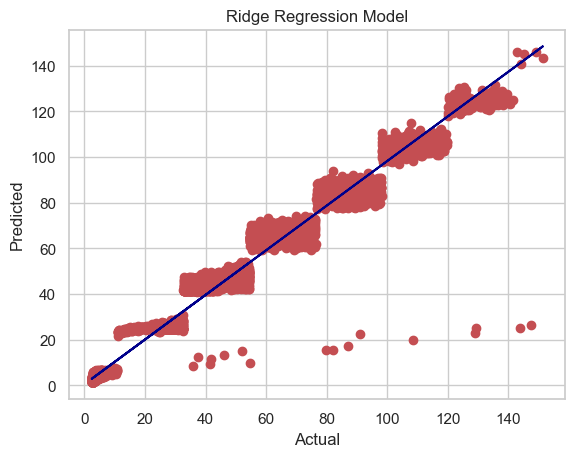

In [49]:
model_ridge = Ridge()

space = dict()
space['solver'] = ['svd', 'lsqr', 'sag']
space['alpha'] = [0.0001, 0.001, 0.01, 0.1, 1, 10]
space['fit_intercept'] = [True, False]
hyperparams_gridsearch = gridsearch(model_ridge, space)

model_ridge.fit_intercept = hyperparams_gridsearch['fit_intercept']
model_ridge.alpha = hyperparams_gridsearch['alpha']
model_ridge.solver = hyperparams_gridsearch['solver']

selected_features = rfe_method(model_ridge)

features, target = selected_features, data['Usage_kWh']
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.3, random_state=0)

model_ridge.fit(features_train, target_train)
train_score = model_ridge.score(features_train, target_train)
test_score = model_ridge.score(features_test, target_test)

print("The train score for ridge model (alpha=" + str(model_ridge.alpha) + ") is {}".format(train_score))
print("The test score for ridge model (alpha=" + str(model_ridge.alpha) + ") is {}".format(test_score))

training_score.append(train_score)
testing_score.append(test_score)

predicted = model_ridge.predict(features_test)

visualize_model(target_test, predicted, "Ridge Regression Model")

### <a id='toc1_3_8_'></a>[Lasso Regression](#toc0_)

Grid Search - Best Score: -2.5344333564492594
Grid Search - Best Hyperparameters: {'alpha': 0.0001, 'fit_intercept': True}
Optimum number of features: 8
Score with 8 features: 0.978826
['Lagging_Current_Reactive.Power_kVarh'
 'Leading_Current_Reactive_Power_kVarh' 'CO2(tCO2)'
 'Lagging_Current_Power_Factor' 'Leading_Current_Power_Factor'
 'WeekStatus' 'Day_of_week' 'Load_Type']
The train score for lasso model (alpha=0.0001) is 0.9810268960946551
The test score for lasso model (alpha=0.0001) is 0.9788259551480127


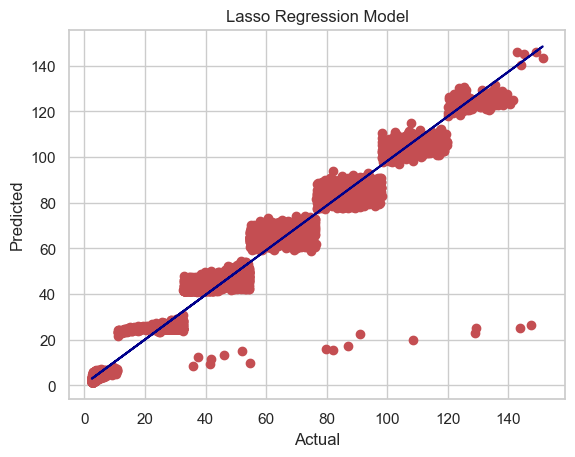

In [50]:
model_lasso = Lasso()

space = dict()
space['alpha'] = [0.0001, 0.001, 0.01, 0.1, 1, 10]
space['fit_intercept'] = [True, False]
hyperparams_gridsearch = gridsearch(model_lasso, space)

model_lasso.fit_intercept = hyperparams_gridsearch['fit_intercept']
model_lasso.alpha = hyperparams_gridsearch['alpha']

selected_features = rfe_method(model_lasso)

features, target = selected_features, data['Usage_kWh']
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.3, random_state=0)

model_lasso.fit(features_train, target_train)
train_score = model_lasso.score(features_train, target_train)
test_score = model_lasso.score(features_test, target_test)

print("The train score for lasso model (alpha=" + str(model_lasso.alpha) + ") is {}".format(train_score))
print("The test score for lasso model (alpha=" + str(model_lasso.alpha) + ") is {}".format(test_score))

training_score.append(train_score)
testing_score.append(test_score)

predicted = model_lasso.predict(features_test)

visualize_model(target_test, predicted, "Lasso Regression Model")

### <a id='toc1_3_9_'></a>[ElasticNet Regression](#toc0_)

Grid Search - Best Score: -5.1159282974895754
Grid Search - Best Hyperparameters: {'alpha': 0.0001, 'fit_intercept': False}
Optimum number of features: 3
Score with 3 features: 0.949066
['CO2(tCO2)' 'WeekStatus' 'Load_Type']
The train score for Elastic Net model (alpha=0.0001) is 0.9531526323877431
The test score for Elastic Net model (alpha=0.0001) is 0.9490660893682034


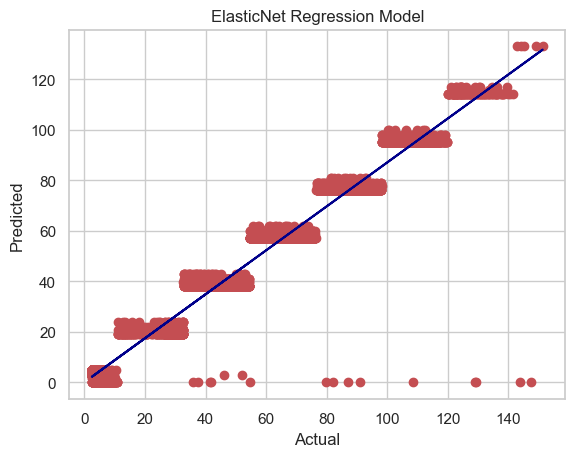

In [51]:
model_elnt = ElasticNet()

space = dict()
space['alpha'] = [0.0001, 0.001, 0.01, 0.1, 1, 10]
space['fit_intercept'] = [True, False]
hyperparams_gridsearch = gridsearch(model_elnt, space)

model_elnt.fit_intercept = hyperparams_gridsearch['fit_intercept']
model_elnt.alpha = hyperparams_gridsearch['alpha']

selected_features = rfe_method(model_elnt)

features, target = selected_features, data['Usage_kWh']
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.3, random_state=0)

model_elnt.fit(features_train, target_train)
train_score = model_elnt.score(features_train, target_train)
test_score = model_elnt.score(features_test, target_test)

print("The train score for Elastic Net model (alpha=" + str(model_elnt.alpha) + ") is {}".format(train_score))
print("The test score for Elastic Net model (alpha=" + str(model_elnt.alpha) + ") is {}".format(test_score))

training_score.append(train_score)
testing_score.append(test_score)

predicted = model_elnt.predict(features_test)

visualize_model(target_test, predicted, "ElasticNet Regression Model")

### <a id='toc1_3_10_'></a>[LinearSVR](#toc0_)
#### <a id='toc1_3_10_1_'></a>[with StandardScaler](#toc0_)

Grid Search - Best Score: -2.3770927576079846
Grid Search - Best Hyperparameters: {'C': 1, 'fit_intercept': True}
Optimum number of features: 6
Score with 6 features: 0.901488
['Lagging_Current_Reactive.Power_kVarh' 'CO2(tCO2)'
 'Lagging_Current_Power_Factor' 'Leading_Current_Power_Factor'
 'WeekStatus' 'Load_Type']
The train score for Linear SVR model (C=1) is 0.9805899074837685
The test score for Linear SVR model (C=1) is 0.9780518272938747


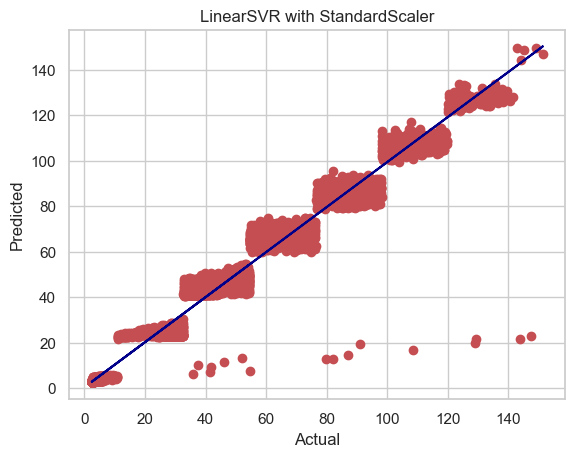

In [53]:
scaler = StandardScaler()

model = LinearSVR()

space = dict()
space['C'] = [0.1, 1, 10, 100]
space['fit_intercept'] = [True, False]
hyperparams_gridsearch = gridsearch(model, space, scaler=scaler)

model.fit_intercept = hyperparams_gridsearch['fit_intercept']
model.C = hyperparams_gridsearch['C']

selected_features = rfe_method(model)

features, target = selected_features, data['Usage_kWh']
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.3, random_state=0)

features_train = scaler.fit_transform(features_train)
features_test = scaler.fit_transform(features_test)

model.fit(features_train, target_train)
train_score = model.score(features_train, target_train)
test_score = model.score(features_test, target_test)

print("The train score for Linear SVR model (C=" + str(model.C) + ") is {}".format(train_score))
print("The test score for Linear SVR model (C=" + str(model.C) + ") is {}".format(test_score))

training_score.append(train_score)
testing_score.append(test_score)

predicted = model.predict(features_test)

visualize_model(target_test, predicted, "LinearSVR with StandardScaler")

#### <a id='toc1_3_10_2_'></a>[with MinMaxScaler](#toc0_)

Grid Search - Best Score: -2.377576467729316
Grid Search - Best Hyperparameters: {'C': 10, 'fit_intercept': True}
Optimum number of features: 1
Score with 1 features: 0.958100
['CO2(tCO2)']
The train score for Linear SVR model (C=10) is 0.9772541658180283
The test score for Linear SVR model (C=10) is 0.9742033009480016


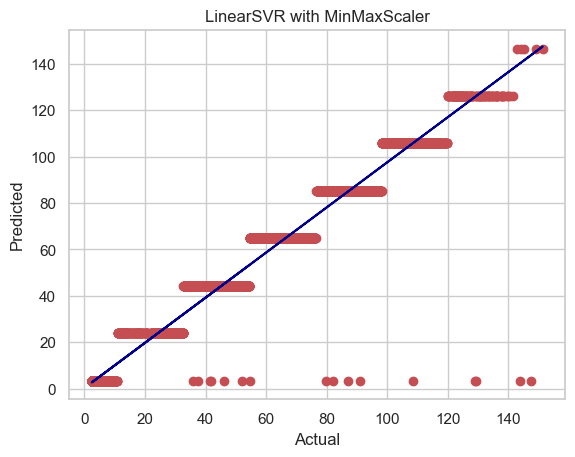

In [54]:
scaler = MinMaxScaler()

model = LinearSVR()

space = dict()
space['C'] = [0.1, 1, 10, 100]
space['fit_intercept'] = [True, False]
hyperparams_gridsearch = gridsearch(model, space, scaler=scaler)

model.fit_intercept = hyperparams_gridsearch['fit_intercept']
model.C = hyperparams_gridsearch['C']

selected_features = rfe_method(model)

features, target = selected_features, data['Usage_kWh']
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.3, random_state=0)

features_train = scaler.fit_transform(features_train)
features_test = scaler.fit_transform(features_test)

model.fit(features_train, target_train)
train_score = model.score(features_train, target_train)
test_score = model.score(features_test, target_test)

print("The train score for Linear SVR model (C=" + str(model.C) + ") is {}".format(train_score))
print("The test score for Linear SVR model (C=" + str(model.C) + ") is {}".format(test_score))

training_score.append(train_score)
testing_score.append(test_score)

predicted = model.predict(features_test)

visualize_model(target_test, predicted, "LinearSVR with MinMaxScaler")

#### <a id='toc1_3_10_3_'></a>[with RobustScaler](#toc0_)

Grid Search - Best Score: -2.4236953957950487
Grid Search - Best Hyperparameters: {'C': 1, 'fit_intercept': True}
Optimum number of features: 8
Score with 8 features: 0.910595
['Lagging_Current_Reactive.Power_kVarh'
 'Leading_Current_Reactive_Power_kVarh' 'CO2(tCO2)'
 'Lagging_Current_Power_Factor' 'Leading_Current_Power_Factor'
 'WeekStatus' 'Day_of_week' 'Load_Type']
The train score for Linear SVR model (C=1) is 0.9806093367078822
The test score for Linear SVR model (C=1) is 0.978213567033693


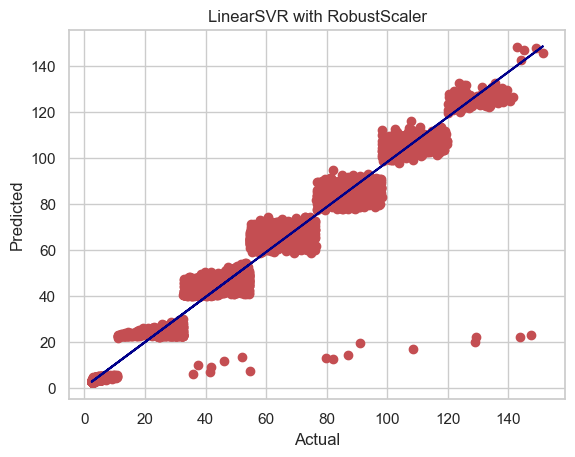

In [55]:
scaler = RobustScaler()

model = LinearSVR()

space = dict()
space['C'] = [0.1, 1, 10, 100]
space['fit_intercept'] = [True, False]
hyperparams_gridsearch = gridsearch(model, space, scaler=scaler)

model.fit_intercept = hyperparams_gridsearch['fit_intercept']
model.C = hyperparams_gridsearch['C']

selected_features = rfe_method(model)

features, target = selected_features, data['Usage_kWh']
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.3, random_state=0)

features_train = scaler.fit_transform(features_train)
features_test = scaler.fit_transform(features_test)

model.fit(features_train, target_train)
train_score = model.score(features_train, target_train)
test_score = model.score(features_test, target_test)

print("The train score for Linear SVR model (C=" + str(model.C) + ") is {}".format(train_score))
print("The test score for Linear SVR model (C=" + str(model.C) + ") is {}".format(test_score))

training_score.append(train_score)
testing_score.append(test_score)

predicted = model.predict(features_test)

visualize_model(target_test, predicted, "LinearSVR with RobustScaler")

<h4>Visualizing results</h4>

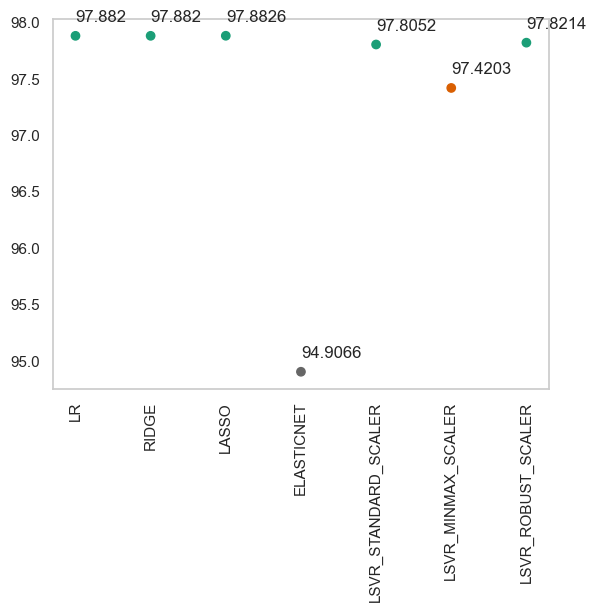

In [56]:
models = ['LR', 'RIDGE', 'LASSO', 'ELASTICNET', 'LSVR_STANDARD_SCALER', 'LSVR_MINMAX_SCALER', 'LSVR_ROBUST_SCALER']
show_results(score_list=testing_score, labels=models)

### <a id='toc1_3_11_'></a>[Ensemble method](#toc0_)

#### <a id='toc1_3_11_1_'></a>[Averaging](#toc0_)

In [57]:
features, target = data.loc[:, data.columns != 'Usage_kWh'], data['Usage_kWh']
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.3, random_state=0)

lr = LinearRegression()
lr.fit(features_train, target_train)

training_score.append(lr.score(features_train, target_train))

lasso = Lasso(alpha=0.0001)
lasso.fit(features_train, target_train)

training_score.append(lasso.score(features_train, target_train))

en = ElasticNet(alpha=0.0001, fit_intercept=False)
en.fit(features_train, target_train)

training_score.append(en.score(features_train, target_train))

rlr = Ridge(alpha=0.0001, solver='svd')
rlr.fit(features_train, target_train)

base_model_prediction = pd.DataFrame({'LR':lr.predict(features_test), 'Lasso':lasso.predict(features_test), 'Ridge':rlr.predict(features_test), 'ELNT':en.predict(features_test)})
display(base_model_prediction.head())

,LR,Lasso,Ridge,ELNT
0,42.395048,42.378282,42.393868,35.998360
1,4.782102,4.796377,4.783097,8.197382
2,4.961038,4.974158,4.961960,16.096559
3,2.750491,2.745351,2.750109,2.719913
4,67.980604,67.997575,67.981819,74.107901


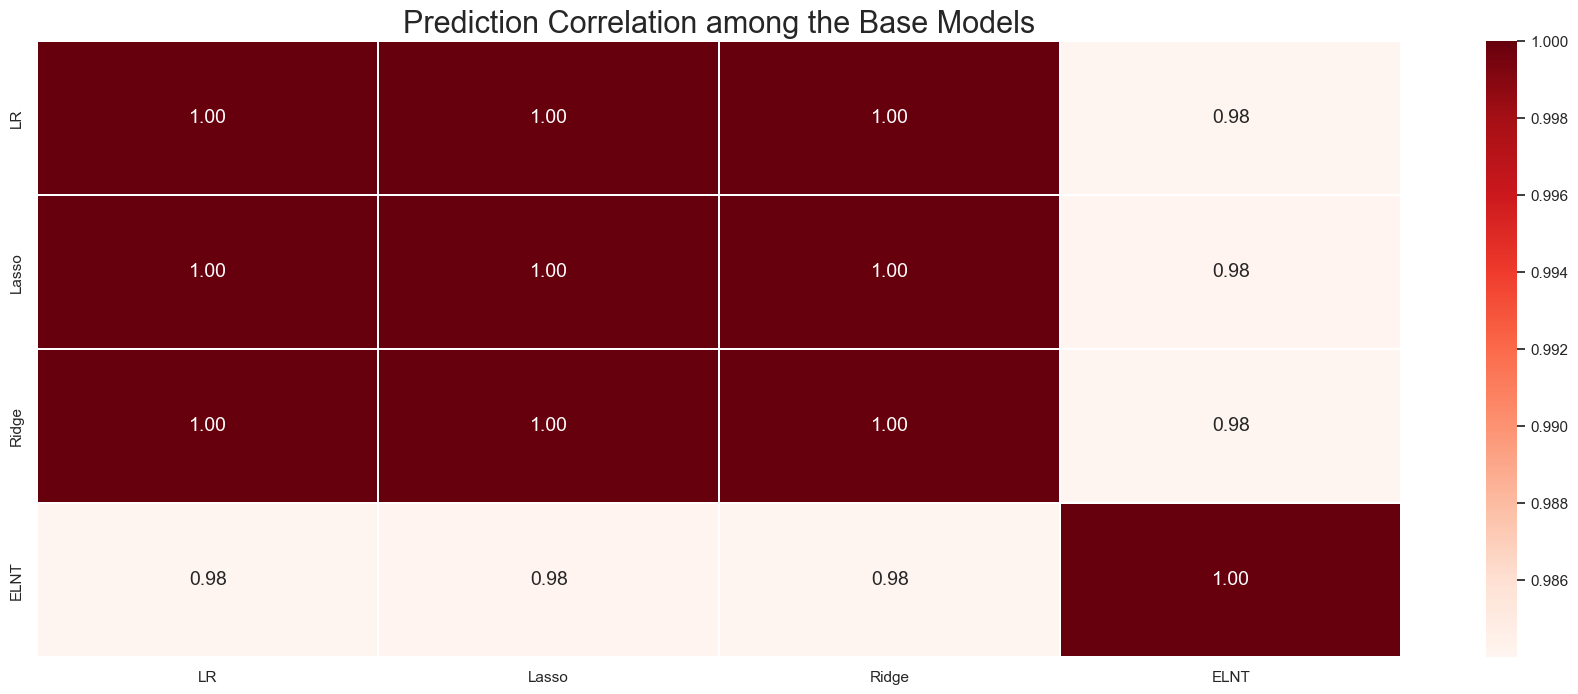

In [58]:
fig, ax = plt.subplots(figsize=(22,8))
sns.heatmap(base_model_prediction.corr(), annot=True, cmap='Reds', ax = ax, fmt = '.2f', linewidths = 0.05, annot_kws = {'size': 14})
ax.set_title('Prediction Correlation among the Base Models', fontsize = 22)
plt.show()

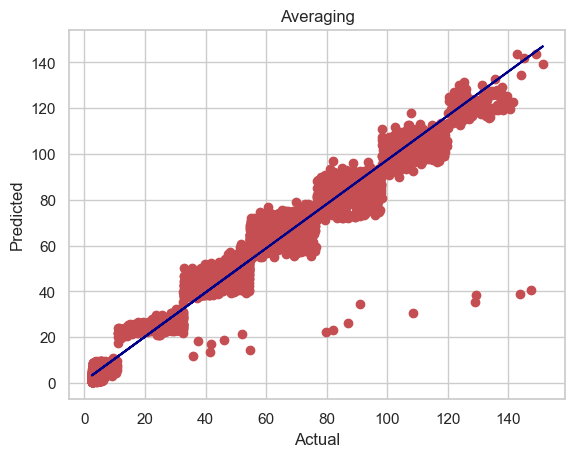

In [59]:
y_lr = lr.predict(features_test)
y_lasso = lasso.predict(features_test)
y_en = en.predict(features_test)
y_rlr = rlr.predict(features_test)

avg_ensemble = (y_lr + y_lasso + y_en + y_rlr)/4
visualize_model(target_test, avg_ensemble, "Averaging")

#### <a id='toc1_3_11_2_'></a>[Stacking](#toc0_)

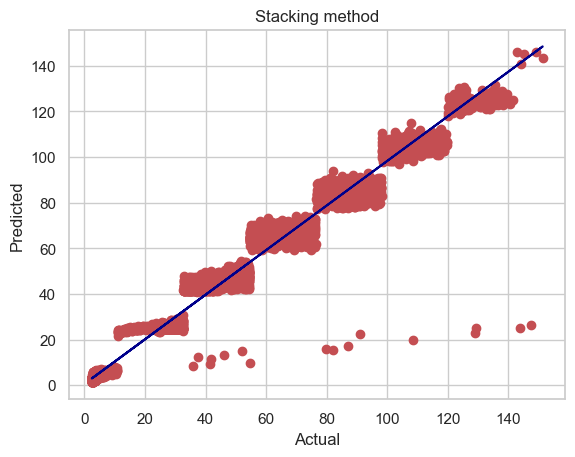

In [ ]:
base_models = [('Lasso', lasso), ('Ridge', rlr), ('ELNT', en)]
stacking_model = StackingRegressor(estimators=base_models, final_estimator=lr, cv=10)
models = dict()
models['Lasso'] = lasso
models['Ridge'] = rlr
models['ELNT'] = en
models['stacking'] = stacking_model

stacking_model.fit(features_train, target_train)
predicted = stacking_model.predict(features_test)
visualize_model(target_test, predicted, "Stacking method")

### <a id='toc1_3_12_'></a>[Discussion](#toc0_)

First two graphs below show model scoring for training data before feature selection and hyperparameters tuning and after, while third graph shows model scoring for testing data after feature selection and hyperparameters. As it can be seen, Lasso Regression and ElasticNet Regression had the best improvement, while the difference between other models is rather small to be taken in consideration, while testing scores still stand high. Generally speaking, excluding LinearSVR models, we can say that models have quite high scores. 

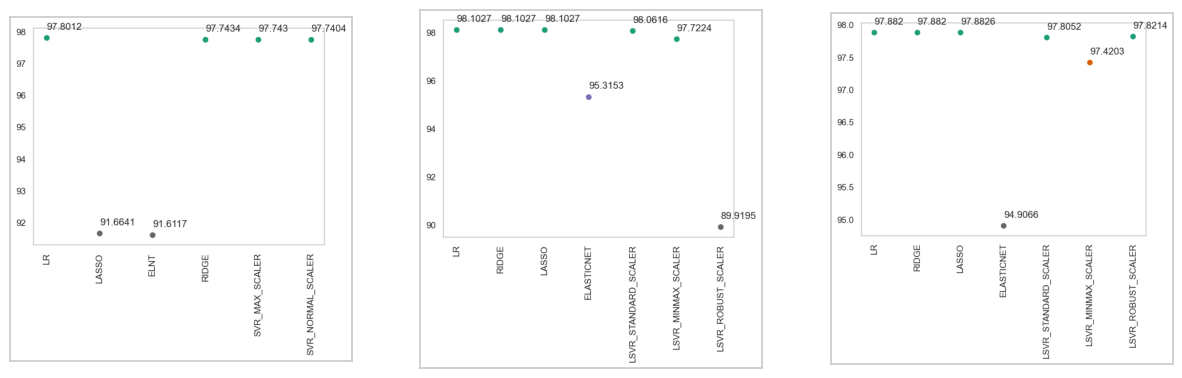

In [67]:
import matplotlib.image as mpimg

img1 = mpimg.imread('results_images/lr.png')
img2 = mpimg.imread('results_images/rr.png')
img3 = mpimg.imread('results_images/lasso.png')
img4 = mpimg.imread('results_images/elnet.png')
img5 = mpimg.imread('results_images/svr_standard.png')
img6 = mpimg.imread('results_images/svr_minmax.png')
img7 = mpimg.imread('results_images/svr_robust.png')
img8 = mpimg.imread('results_images/all_simple.png')
img9 = mpimg.imread('results_images/all_engineered.png')
img10 = mpimg.imread('results_images/averaging.png')
img11 = mpimg.imread('results_images/stacking.png')
img12 = mpimg.imread('results_images/all_engineered_test.png')

fig, ((ax1,ax2,ax3)) = plt.subplots(nrows=1,ncols=3,figsize=(15,10))

ax1.imshow(img8)
ax2.imshow(img9)
ax3.imshow(img12)

ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
ax3.get_xaxis().set_visible(False)
ax3.get_yaxis().set_visible(False)

plt.show()

Graphs below show the performance of the models. The models that have similar scores (Linear Regression, Rigde Regression and Lasso Regression) also have similar distribution of predicted values. We can see that Ensemble methods also have similar distribution of predicted values, which was expected result as seen on the model correlation heatmap previously. The most difference in prediction values can be seen for LinearSVR with Standrad Scaler and with Robust Scaler which is expected from the scores in previous graphs.

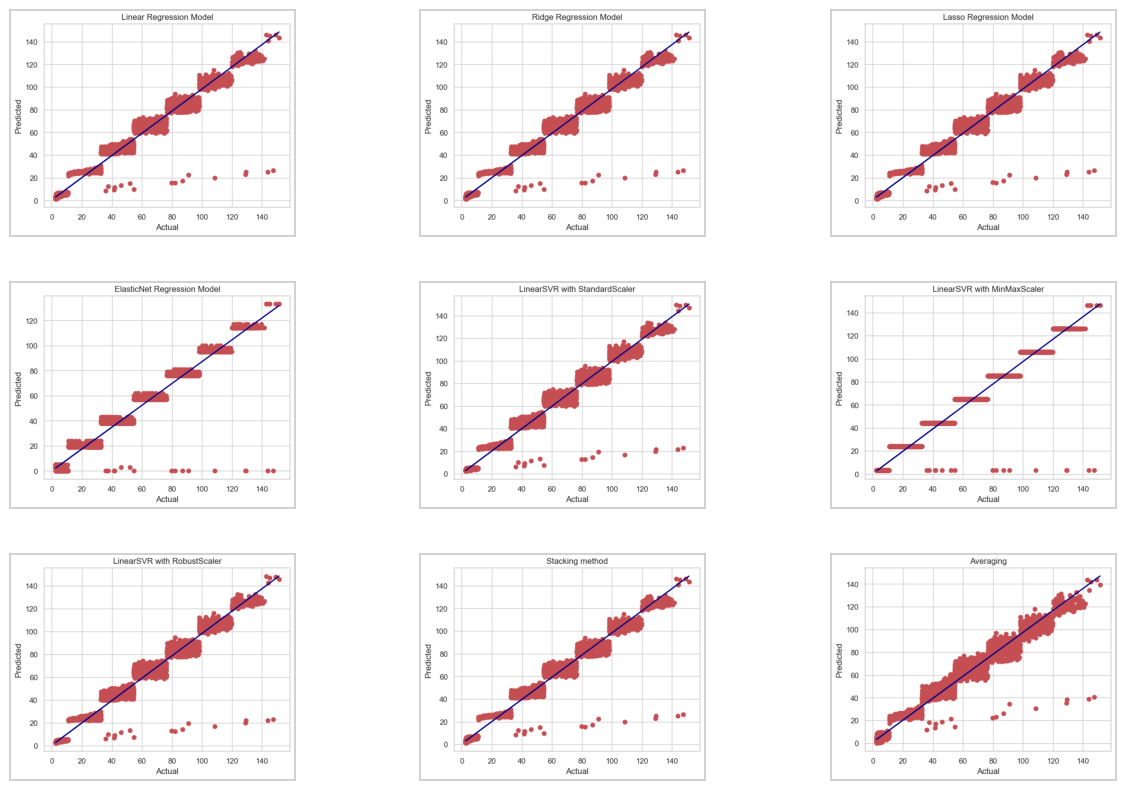

In [64]:
fig, ((ax1,ax2,ax3),(ax4,ax5,ax6),(ax7,ax8,ax9)) = plt.subplots(nrows=3,ncols=3,figsize=(15,10))

ax1.imshow(img1)
ax2.imshow(img2)
ax3.imshow(img3)
ax4.imshow(img4)
ax5.imshow(img5)
ax6.imshow(img6)
ax7.imshow(img7)
ax8.imshow(img11)
ax9.imshow(img10)

ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
ax3.get_xaxis().set_visible(False)
ax3.get_yaxis().set_visible(False)
ax4.get_xaxis().set_visible(False)
ax4.get_yaxis().set_visible(False)
ax5.get_xaxis().set_visible(False)
ax5.get_yaxis().set_visible(False)
ax6.get_xaxis().set_visible(False)
ax6.get_yaxis().set_visible(False)
ax7.get_xaxis().set_visible(False)
ax7.get_yaxis().set_visible(False)
ax8.get_xaxis().set_visible(False)
ax8.get_yaxis().set_visible(False)
ax9.get_xaxis().set_visible(False)
ax9.get_yaxis().set_visible(False)

plt.show()

Taking everything in consideration, we can say that for given dataset, highly accurate models for prediction of energy consumption can be achived.